<a href="https://colab.research.google.com/github/andreclaudino/pos-puc-rio-mvp-ciencia-de-dados/blob/main/notebook-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Patrimômio e poder - A influência dos Bens nas Eleições municipais de 2024


## Introdução
Neste estudo, eu farei uma análise da relação entre bens de candidatos e as chances de vitória nas eleições municipais de 2024. O alvo principal deste estudo é a relação entre os bens declarados pelos candidatos e a situação dos mesmos ao final das eleições, porém, vamos considerar também outros fatores como grau de instrução, gênero, raça, idade e estado civil.



## Premissas

Assumimos as seguintes premissas:

* Os bens declarados refletem razoavelmente o patrimônio real dos candidatos (reconhecendo a possibilidade de subdeclaração).
* Assumimos que dentro do possível, as diferenças econômicas entre as regiões não influenciam os resultados.
* Sabemos que há outros fatores que influenciam a eleição, mas nos concentraremos nos dados que possuímos assumindo que são suficientes
* Assumimos que dentro da mesma eleição (candidatos que competem entre si), os candidatos são suficientemente comparáveis.
* O foco será apenas nos candidatos à vereador
* Como foco é apenas em vereadores, consideraremos apenas candidaturas no primeiro turno.
* Consideraremos apenas as eleições ordinárias



## Hipóteses

* O Patrimônio de um candidato está relacionado com as suas chances de ser eleito?
* Candidatos com a ocupação VEREADOR tem mais chances de ser eleitos (ou seja, há mais chances de reeleição)?
* A raça do candidato está ligada a ter maior patrimônio ou a ter mais chances de ser eleito?




## Dados envolvidos

Há dois datasets para serem analisados:

* `consulta_cand_2024_BRASIL.csv`: Este dataset apresenta dados de grau de instrução, gênero, raça, idade e estado civil, a situação do candidato ao final da eleição, sua afiliação partidária e a eleição na qual concorreu.
* `bem_candidato_2024_BRASIL.csv`: Aqui temos os bens delcarados pelos candidatos na eleição em questão, incluindo o tipo do bem e o valor.
* `consulta_vagas_2024_BRASIL.csv`: Contém informações de vagas disponíveis para as eleições

Os dicionários de dados se encontram nos arquivos com extensão pdf de mesmo nome que os arquivos de dados. à Seguir, apresento algumas informações para colunas relevantes.

Os arquivos tem muitas coluneas, ao longo da análise reforço as relevantes, mas para a lista e a explicação de cada uma delas, pode-se olhar a documentação do dataset, que contém o dicionário de dados.

* [bens de candidatos](https://github.com/andreclaudino/pos-puc-rio-mvp-ciencia-de-dados/blob/main/dados/bem_candidato_2024_BRASIL.pdf)
* [Informações de candidatos](https://github.com/andreclaudino/pos-puc-rio-mvp-ciencia-de-dados/blob/main/dados/consulta_cand_2024_BRASIL.pdf)
* [Vagas disponíveis](https://github.com/andreclaudino/pos-puc-rio-mvp-ciencia-de-dados/blob/main/dados/consulta_vagas_2024_BRASIL.pdf)

# Execução da análise

## Importação das dependências

O projeto foi organizado seguindo boas práticas de código, e portanto, as funções de carregamento e preparação estão no módulo `mvp`.

Antes de tudo, precisamos clonar os módulos com o projeto do MBA e os dados do github:

In [1]:
!git clone https://github.com/andreclaudino/pos-puc-rio-mvp-ciencia-de-dados
!pip install -e pos-puc-rio-mvp-ciencia-de-dados/
!cp -r pos-puc-rio-mvp-ciencia-de-dados/src/mvp mvp
!cp -r pos-puc-rio-mvp-ciencia-de-dados/dados dados

Cloning into 'pos-puc-rio-mvp-ciencia-de-dados'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 43 (delta 3), reused 4 (delta 0), pack-reused 30 (from 1)
Receiving objects: 100% (43/43), 57.21 MiB | 31.80 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Obtaining file:///content/pos-puc-rio-mvp-ciencia-de-dados
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mvp (pyproject.toml) ... done
  Created wheel for mvp: filename=mvp-0.1.0-0.editable-py3-none-any.whl size=1196 sha256=6f94e991f84137ee691eb146fdfdd4f6c907eb68d1d7a6a685494f6c6234df44
  Stored in directory: /tmp/pip-ephem-wheel-cache-5q9ko0ut/wheels/56/42/6a/fb8e4edaac1347eb412438c7fd6e23971cbab9cd6f4d2ff96c
Successfully built mvp


In [2]:
import os
from mvp.persistence.loaders import load_data_source
from mvp.session_utils import create_spark_session

from mvp.preprocessors import remove_columns, rename_columns, sort_by_categorical_field, \
    parse_text_to_float_udf, remove_group_outliers, replace_outliers, calculate_group_dispersion
from mvp.analysis import count_column_occurencies, measure_column_value_proportions

from mvp.visualization import create_bar_chart, create_pie_chart, create_histogram

from pyspark.sql.functions import col, lit

from mvp.constants import GRAUS_DE_INSTRUCAO_SORT_ORDER

from mvp.domain.candidatos import mescla_estados_civis_udf, mescla_ocupação_udf, \
    calcula_idade_no_ano_udf, mescla_situacao_no_turno_udf, segmenta_idade_udf

from mvp.domain.bens_de_candidatos import calcula_patrimonio

from mvp.training import separa_treino_e_teste
from mvp.training import preapre_feature_engineering_pipeline

## Preparação do ambiente

Aqui preparamos o ambiente spark para processamento, definindo as entradas, construindo a sessão e definindo configurações do ambiente

In [3]:
dados_de_candidatos_source_path = "dados/consulta_cand_2024_BRASIL.csv.gz"
bens_de_candidados_source_path = "dados/bem_candidato_2024_BRASIL.csv.gz"
vagas_por_eleicao_source_path = "dados/consulta_vagas_2024_BRASIL.csv.gz"

Vamos definir também o caminho principal de saída, à partir dele, todos os demais serão criados.

In [4]:
output_path = "outputs"

In [5]:
# Inicializa sessão do Spark
spark = create_spark_session()


## Dados de candidatos

Vamos começar com os dados de candidatos.

In [6]:
# Carrega os dados de candidatos
dados_de_candidatos = load_data_source(spark, dados_de_candidatos_source_path)

### Remoção de colunas

Pelo dicionário de dados entendemos que algumas colunas não são relevantes para nossa análise. Algumas não representam informações de interesse para nossa pesquisa, e outras são apenas códigos numéricos redundantes com informações de outras colunas de interesse.

Vamos começar a limpeza deste dataset removendo as colunas que não nos interessam para esta pesquisa.

In [7]:
# Remove columas irrelevantes
columns_to_remove_from_dados_de_candidatos = [
    "DT_GERACAO",
    "HH_GERACAO",
    "ANO_ELEICAO",
    "DT_ELEICAO",
    "CD_TIPO_ELEICAO",
    "CD_CARGO",
    "CD_SITUACAO_CANDIDATURA",
    "DS_SITUACAO_CANDIDATURA",
    "TP_AGREMIACAO",
    "NR_PARTIDO",
    "NM_PARTIDO",
    "CD_GENERO",
    "CD_GRAU_INSTRUCAO",
    "CD_ESTADO_CIVIL",
    "CD_COR_RACA",
    "CD_OCUPACAO",
    "CD_SIT_TOT_TURNO",
    "NR_TITULO_ELEITORAL_CANDIDATO",
    "NR_CPF_CANDIDATO",
    "NR_CANDIDATO",
    "NM_URNA_CANDIDATO",
    "NM_SOCIAL_CANDIDATO",
    "NR_FEDERACAO",
    "SG_FEDERACAO",
    "NM_COLIGACAO",
    "DS_COMPOSICAO_COLIGACAO",
    "DS_COMPOSICAO_FEDERACAO",
    "DS_EMAIL",
    "SG_UF_NASCIMENTO",
    "SQ_COLIGACAO",
    "SG_PARTIDO",
    "TP_ABRANGENCIA",
    "SQ_COLIGACAO",
    "SG_UF_NASCIMENTO",
    "NM_CANDIDATO",
    "NM_FEDERACAO"
]

dados_de_candidatos = remove_columns(dados_de_candidatos, columns_to_remove_from_dados_de_candidatos)
dados_de_candidatos.printSchema()

root
 |-- NM_TIPO_ELEICAO: string (nullable = true)
 |-- NR_TURNO: string (nullable = true)
 |-- CD_ELEICAO: string (nullable = true)
 |-- DS_ELEICAO: string (nullable = true)
 |-- SG_UF: string (nullable = true)
 |-- SG_UE: string (nullable = true)
 |-- NM_UE: string (nullable = true)
 |-- DS_CARGO: string (nullable = true)
 |-- SQ_CANDIDATO: string (nullable = true)
 |-- DT_NASCIMENTO: string (nullable = true)
 |-- DS_GENERO: string (nullable = true)
 |-- DS_GRAU_INSTRUCAO: string (nullable = true)
 |-- DS_ESTADO_CIVIL: string (nullable = true)
 |-- DS_COR_RACA: string (nullable = true)
 |-- DS_OCUPACAO: string (nullable = true)
 |-- DS_SIT_TOT_TURNO: string (nullable = true)



Para tornar a compreensão mais clara, vamos renomear as colunas, gerando um schema mais legível.

In [8]:
column_renames_on_dados_de_candidatos = {
    "NM_TIPO_ELEICAO": "tipo_eleicao",
    "NR_TURNO": "turno",
    "CD_ELEICAO": "codigo_eleicao",
    "DS_ELEICAO": "descricao_eleicao",
    "SG_UF": "uf",
    "SG_UE": "codigo_unidade_eleitoral",
    "NM_UE": "unidade_eleitoral",
    "DS_CARGO": "cargo",
    "SQ_CANDIDATO": "codigo_candidato",
    "DT_NASCIMENTO": "data_nascimento",
    "DS_GENERO": "genero",
    "DS_GRAU_INSTRUCAO": "grau_instrucao",
    "DS_ESTADO_CIVIL": "estado_civil",
    "DS_COR_RACA": "cor_raca",
    "DS_OCUPACAO": "ocupacao",
    "DS_SIT_TOT_TURNO": "situacao_no_turno"
}

dados_de_candidatos = rename_columns(dados_de_candidatos, column_renames_on_dados_de_candidatos)
dados_de_candidatos.printSchema()

root
 |-- tipo_eleicao: string (nullable = true)
 |-- turno: string (nullable = true)
 |-- codigo_eleicao: string (nullable = true)
 |-- descricao_eleicao: string (nullable = true)
 |-- uf: string (nullable = true)
 |-- codigo_unidade_eleitoral: string (nullable = true)
 |-- unidade_eleitoral: string (nullable = true)
 |-- cargo: string (nullable = true)
 |-- codigo_candidato: string (nullable = true)
 |-- data_nascimento: string (nullable = true)
 |-- genero: string (nullable = true)
 |-- grau_instrucao: string (nullable = true)
 |-- estado_civil: string (nullable = true)
 |-- cor_raca: string (nullable = true)
 |-- ocupacao: string (nullable = true)
 |-- situacao_no_turno: string (nullable = true)



In [9]:
dados_de_candidatos.show(10, truncate=False)

+-------------------+-----+--------------+-----------------------------+---+------------------------+-------------------+--------+----------------+---------------+---------+-----------------------------+------------+--------+------------------------------------+-----------------+
|tipo_eleicao       |turno|codigo_eleicao|descricao_eleicao            |uf |codigo_unidade_eleitoral|unidade_eleitoral  |cargo   |codigo_candidato|data_nascimento|genero   |grau_instrucao               |estado_civil|cor_raca|ocupacao                            |situacao_no_turno|
+-------------------+-----+--------------+-----------------------------+---+------------------------+-------------------+--------+----------------+---------------+---------+-----------------------------+------------+--------+------------------------------------+-----------------+
|ELEIÇÃO SUPLEMENTAR|1    |6200          |Eleição suplementar Guapé    |MG |45616                   |GUAPÉ              |PREFEITO|130002515251    |15/09/1987

Agora vamos analisar os diferentes valores das colunas, tanto para entender quais valores não são relevantes quanto para encontrar valores nulos/inválidos, ou que os representem e seguir com a limpeza do dataset.

In [10]:
count_column_occurencies(dados_de_candidatos, "turno").show()

+-----+------+
|turno| count|
+-----+------+
|    1|463441|
|    2|   204|
+-----+------+



De acordo com as premissas, só temos interesse no primeiro turno, então vamos excluir as linhas relacionadas ao segundo turno.

In [11]:
dados_de_candidatos = dados_de_candidatos.filter(col("turno") == lit(1))
dados_de_candidatos = remove_columns(dados_de_candidatos, ["turno"])

In [12]:
count_column_occurencies(dados_de_candidatos, "descricao_eleicao").show(truncate=False)

+-------------------------------------+------+
|descricao_eleicao                    |count |
+-------------------------------------+------+
|Eleição Suplementar - Ruy Barbosa    |4     |
|Eleição Suplementar Paranhos-MS      |4     |
|Eleição Suplementar de Bocaina       |8     |
|Eleição Suplementar de Eldorado      |6     |
|Eleição Suplementar de Goiana        |4     |
|Eleição Suplementar de Mongaguá      |4     |
|Eleição Suplementar de Neves Paulista|6     |
|Eleição Suplementar de Panorama      |4     |
|Eleição suplementar Guapé            |7     |
|Eleições Municipais 2024             |463394|
+-------------------------------------+------+



De acordo com as premissas, só temos interesse nas `Eleições Municipais 2024`, então vamos excluir as demais.

In [13]:
dados_de_candidatos = dados_de_candidatos.filter(col("descricao_eleicao") == lit("Eleições Municipais 2024"))
dados_de_candidatos = remove_columns(dados_de_candidatos, ["descricao_eleicao"])

In [14]:
count_column_occurencies(dados_de_candidatos, "cargo").show(truncate=False)

+-------------+------+
|cargo        |count |
+-------------+------+
|PREFEITO     |15574 |
|VEREADOR     |432002|
|VICE-PREFEITO|15818 |
+-------------+------+



De acordo com as premissas, nossa candidatura é apenas para o cargo de VEREADOR, então, excluímos as demais.

In [15]:
dados_de_candidatos = dados_de_candidatos.filter(col("cargo") == "VEREADOR")
dados_de_candidatos = remove_columns(dados_de_candidatos, ["cargo"])

### Gênero

Vamos analisar o gênero declarado do candidato

In [16]:
count_column_occurencies(dados_de_candidatos, "genero").show(truncate=False)
measure_column_value_proportions(dados_de_candidatos, "genero").show(truncate=False)

+--------------+------+
|genero        |count |
+--------------+------+
|FEMININO      |152946|
|MASCULINO     |279016|
|NÃO DIVULGÁVEL|40    |
+--------------+------+

+--------------+--------------------+
|genero        |proportion          |
+--------------+--------------------+
|FEMININO      |0.35404002759246483 |
|MASCULINO     |0.64586738024361    |
|NÃO DIVULGÁVEL|9.259216392516702E-5|
+--------------+--------------------+



Existe um grupo, `NÃO DIVULGÁVEL`, que corresponde à proporção de $9e-5$ do dataset, o que corresponde à aproximadamente $0,009\%$, tornando-o descartável frente aos demais grupos que correspondem à $35\%$ e $64\%$, vamos então simplificar a análise removendo este grupo.

In [17]:
dados_de_candidatos = dados_de_candidatos.filter((col("genero") == lit("MASCULINO")) | (col("genero") == lit("FEMININO")))

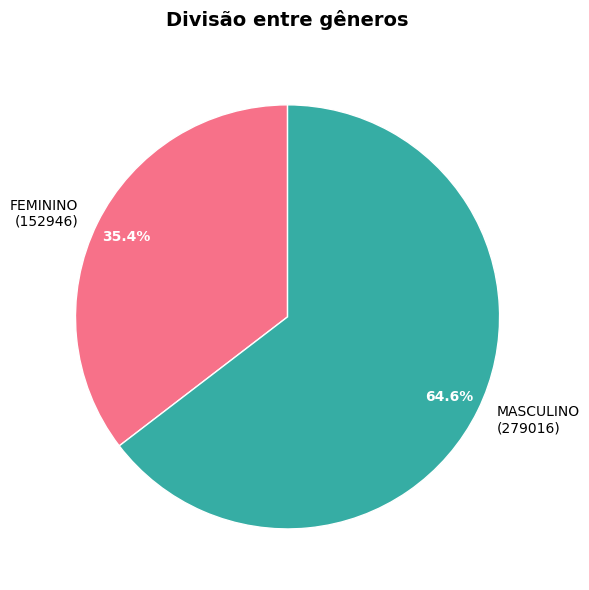

In [18]:
generos_de_candidatos = count_column_occurencies(dados_de_candidatos, "genero")

create_pie_chart(
    generos_de_candidatos,
    category_column_name = "genero",
    count_column_name="count",
    title = "Divisão entre gêneros",
    height = 6, width = 6
).show()

A base de candidatos do gênero feminino é de aproximadamente 1/3 do total, curiosamente, o mínimo requisitado por lei.

### Grau de instrução

Agora, vamos observar o grau de instrução.

+-----------------------------+------+
|grau_instrucao               |count |
+-----------------------------+------+
|ANALFABETO                   |13    |
|LÊ E ESCREVE                 |9655  |
|ENSINO FUNDAMENTAL INCOMPLETO|46584 |
|ENSINO FUNDAMENTAL COMPLETO  |49052 |
|ENSINO MÉDIO INCOMPLETO      |20307 |
|ENSINO MÉDIO COMPLETO        |172040|
|SUPERIOR INCOMPLETO          |19686 |
|SUPERIOR COMPLETO            |114625|
+-----------------------------+------+

+-----------------------------+---------------------+
|grau_instrucao               |proportion           |
+-----------------------------+---------------------+
|ANALFABETO                   |3.0095239859061675E-5|
|LÊ E ESCREVE                 |0.022351503141480038 |
|ENSINO FUNDAMENTAL INCOMPLETO|0.10784281950727147  |
|ENSINO FUNDAMENTAL COMPLETO  |0.1135562850435918   |
|ENSINO MÉDIO INCOMPLETO      |0.047011079678305034 |
|ENSINO MÉDIO COMPLETO        |0.3982757742579208   |
|SUPERIOR INCOMPLETO          |0.045573453220

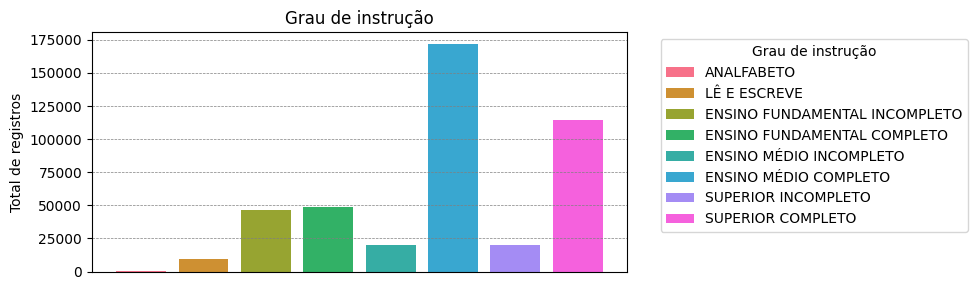

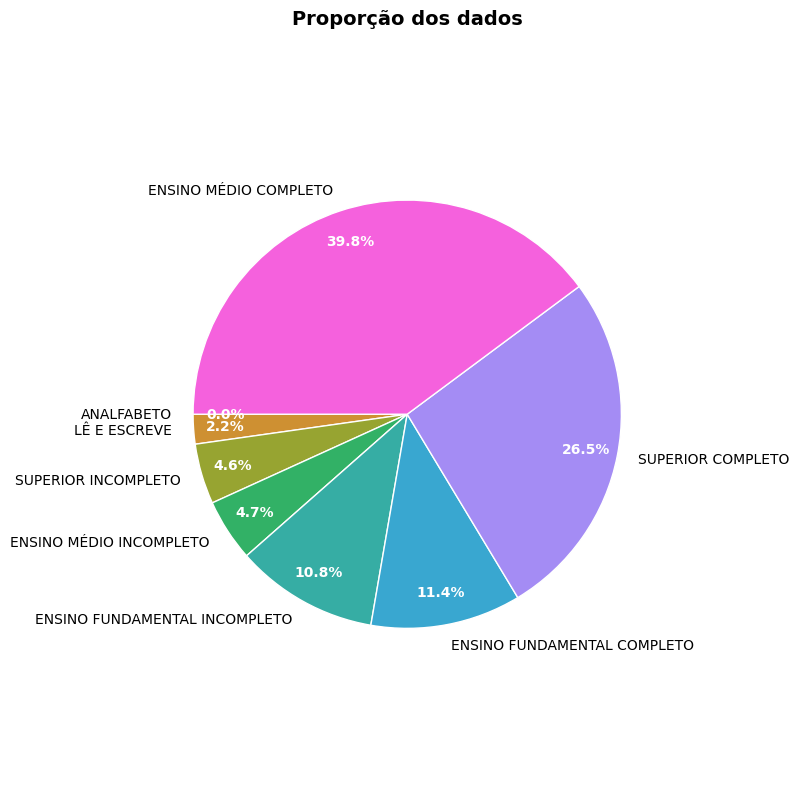

In [19]:
grau_de_instrucao_dos_candidatos = count_column_occurencies(
    dados_de_candidatos, "grau_instrucao")
grau_de_instrucao_dos_candidatos = sort_by_categorical_field(
    spark, grau_de_instrucao_dos_candidatos, GRAUS_DE_INSTRUCAO_SORT_ORDER, "grau_instrucao")
grau_de_instrucao_dos_candidatos.show(truncate=False)

grau_de_instrução_proportions = measure_column_value_proportions(
    dados_de_candidatos, "grau_instrucao")
grau_de_instrução_proportions = sort_by_categorical_field(
    spark, grau_de_instrução_proportions, GRAUS_DE_INSTRUCAO_SORT_ORDER, "grau_instrucao")
grau_de_instrução_proportions.show(truncate=False)

create_bar_chart(
    grau_de_instrucao_dos_candidatos,
    category_column_name="grau_instrucao",
    count_column_name="count",
    category_label="Grau de instrução",
    count_label="Total de registros",
    title="Grau de instrução",
    height=3, width=10,
    use_legends=True
).show()

create_pie_chart(
    grau_de_instrução_proportions,
    category_column_name="grau_instrucao",
    count_column_name="proportion",
    title="Proporção dos dados",
    height=8, width=8,
    startangle = 180,
    include_value_labels=False
).show()

Sobre o grau de instrução, existem muito poucos candidatos no nível `ANALFABETO` comparando aos demais (menos de 1%) . Como este valor é irrelevante frente aos demais, podemos excluir.

In [20]:
dados_de_candidatos = dados_de_candidatos.filter(col("grau_instrucao") != "ANALFABETO")

### Estado civil

Agora, vamos analisar os valores para o estado civil:

+-------------------------+------+
|estado_civil             |count |
+-------------------------+------+
|CASADO(A)                |213364|
|DIVORCIADO(A)            |41077 |
|SEPARADO(A) JUDICIALMENTE|3473  |
|SOLTEIRO(A)              |165235|
|VIÚVO(A)                 |8800  |
+-------------------------+------+

+-------------------------+--------------------+
|estado_civil             |proportion          |
+-------------------------+--------------------+
|CASADO(A)                |0.4939564624527433  |
|DIVORCIADO(A)            |0.09509687486254165 |
|SEPARADO(A) JUDICIALMENTE|0.008040301054059623|
|SOLTEIRO(A)              |0.38253358614095645 |
|VIÚVO(A)                 |0.020372775489699017|
+-------------------------+--------------------+



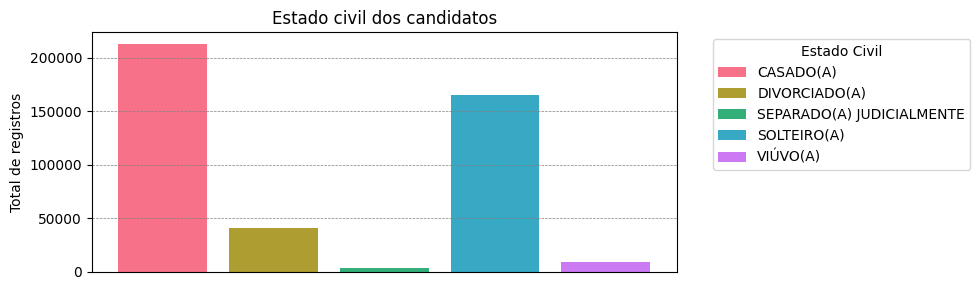

In [21]:
estado_civil_dos_candidatos = count_column_occurencies(dados_de_candidatos, "estado_civil")
estado_civil_dos_candidatos.show(truncate=False)
measure_column_value_proportions(dados_de_candidatos, "estado_civil").show(truncate=False)

create_bar_chart(
    estado_civil_dos_candidatos,
    category_column_name = "estado_civil",
    count_column_name="count",
    category_label= "Estado Civil",
    count_label = "Total de registros",
    title = "Estado civil dos candidatos",
    height = 3, width = 10,
    use_legends=True
).show()

Para fins de comparação, os estados civis `SEPARADO(A) JUDICIALMENTE` e `DIVORCIADO(A)` são equivalentes do ponto de vista do eleitor, então vamos assumir ambos como o mesmo estado civil que criaremos, chamado `SEPARADO`.

+------------+------+
|estado_civil|count |
+------------+------+
|CASADO(A)   |213364|
|SEPARADO    |44550 |
|SOLTEIRO(A) |165235|
|VIÚVO(A)    |8800  |
+------------+------+

+------------+--------------------+
|estado_civil|proportion          |
+------------+--------------------+
|CASADO(A)   |0.4939564624527433  |
|SEPARADO    |0.10313717591660126 |
|SOLTEIRO(A) |0.38253358614095645 |
|VIÚVO(A)    |0.020372775489699017|
+------------+--------------------+



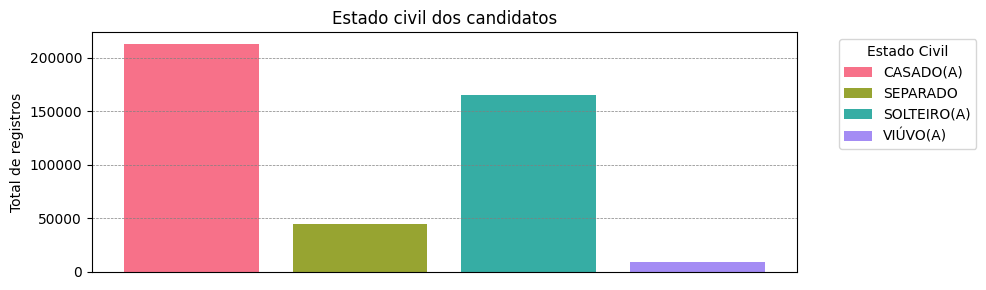

In [22]:
dados_de_candidatos = dados_de_candidatos.withColumn("estado_civil", mescla_estados_civis_udf(col("estado_civil")))

estado_civil_dos_candidatos = count_column_occurencies(dados_de_candidatos, "estado_civil")
estado_civil_dos_candidatos.show(truncate=False)
measure_column_value_proportions(dados_de_candidatos, "estado_civil").show(truncate=False)

create_bar_chart(
    estado_civil_dos_candidatos,
    category_column_name = "estado_civil",
    count_column_name="count",
    category_label= "Estado Civil",
    count_label = "Total de registros",
    title = "Estado civil dos candidatos",
    height = 3, width = 10,
    use_legends=True
).show()

### Cor/Raça

Nesta seção, estudaremos a coluna raça declarada

+-------------+------+
|cor_raca     |count |
+-------------+------+
|AMARELA      |1678  |
|BRANCA       |197767|
|INDÍGENA     |2460  |
|NÃO INFORMADO|2658  |
|PARDA        |176621|
|PRETA        |50765 |
+-------------+------+

+-------------+---------------------+
|cor_raca     |proportion           |
+-------------+---------------------+
|AMARELA      |0.0038847178717857896|
|BRANCA       |0.4578480329853756   |
|INDÍGENA     |0.005695116784620407 |
|NÃO INFORMADO|0.006153504233138634 |
|PARDA        |0.4088931795188784   |
|PRETA        |0.11752544860620119  |
+-------------+---------------------+



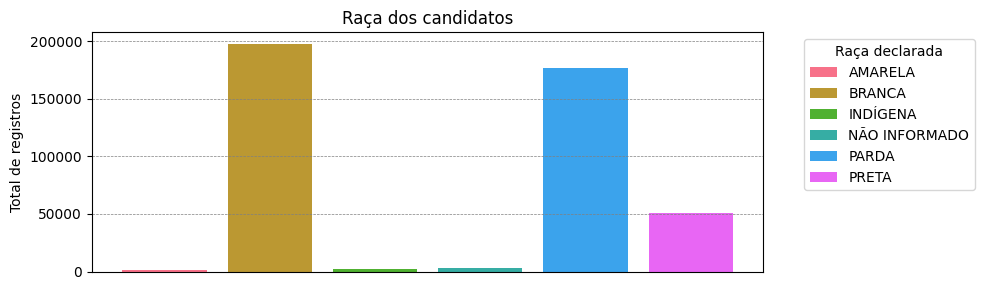

In [23]:
dados_de_candidatos = dados_de_candidatos.withColumn("cor_raca", mescla_estados_civis_udf(col("cor_raca")))

raca_dos_candidatos = count_column_occurencies(dados_de_candidatos, "cor_raca")
raca_dos_candidatos.show(truncate=False)
measure_column_value_proportions(dados_de_candidatos, "cor_raca").show(truncate=False)

create_bar_chart(
    raca_dos_candidatos,
    category_column_name = "cor_raca",
    count_column_name="count",
    category_label= "Raça declarada",
    count_label = "Total de registros",
    title = "Raça dos candidatos",
    height = 3, width = 10,
    use_legends=True
).show()

Os grupos `INDÍGENA`, `AMARELA` e `NÃO INFORMADO` correspondem individualmente a menos de 1% da base cada um. Surgem duas hipóteses:

* Somar estes grupos criando um grupo `OUTROS`: somando-os, teremos um percentual em torno de 1,5%, o que ainda será baixo frente aos demais.
* Excluir os dados relacionados a estes grupos.

Como a soma ainda será muito baixa frente aos demais, apenas excluirei os dados destes grupos.

+--------+------+
|cor_raca|count |
+--------+------+
|BRANCA  |197767|
|PARDA   |176621|
|PRETA   |50765 |
+--------+------+

+--------+-------------------+
|cor_raca|proportion         |
+--------+-------------------+
|BRANCA  |0.46516665765030474|
|PARDA   |0.41542926899257443|
|PRETA   |0.11940407335712085|
+--------+-------------------+



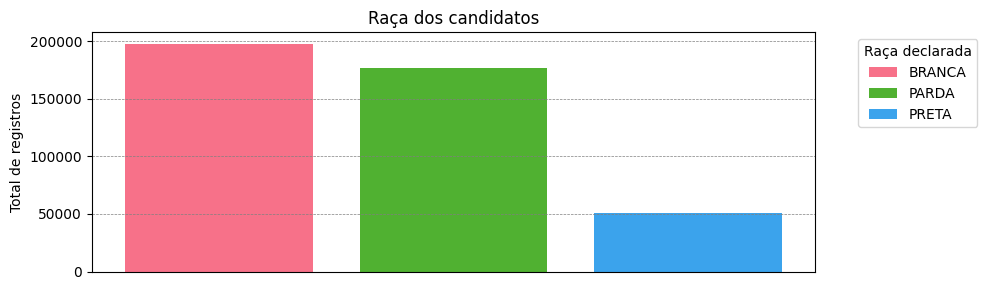

In [24]:
dados_de_candidatos = dados_de_candidatos.filter((col("cor_raca") != lit("INDÍGENA")) & (col("cor_raca") != lit("AMARELA")) & (col("cor_raca") != lit("NÃO INFORMADO")))

raca_dos_candidatos = count_column_occurencies(dados_de_candidatos, "cor_raca")
raca_dos_candidatos.show(truncate=False)
measure_column_value_proportions(dados_de_candidatos, "cor_raca").show(truncate=False)

create_bar_chart(
    raca_dos_candidatos,
    category_column_name = "cor_raca",
    count_column_name="count",
    category_label= "Raça declarada",
    count_label = "Total de registros",
    title = "Raça dos candidatos",
    height = 3, width = 10,
    use_legends=True
).show()

### Ocupação e Reeleição

Para ocupação, temos interesse apenas em saber se o candidato está buscando a reeleição, ou seja, se possui a ocupação `VEREADOR`. Assim sendo, vamos começar extraindo uma nova coluna à partir da coluna ocupação, a coluna `busca_reeleicao`, e à partir disso, a coluna `ocupacao` perderá a relevância.

In [25]:
dados_de_candidatos = \
    dados_de_candidatos\
        .withColumn("busca_reeleicao", mescla_ocupação_udf(col("ocupacao")))\
        .drop("ocupacao")

dados_de_candidatos.printSchema()
dados_de_candidatos.show(10)

root
 |-- tipo_eleicao: string (nullable = true)
 |-- codigo_eleicao: string (nullable = true)
 |-- uf: string (nullable = true)
 |-- codigo_unidade_eleitoral: string (nullable = true)
 |-- unidade_eleitoral: string (nullable = true)
 |-- codigo_candidato: string (nullable = true)
 |-- data_nascimento: string (nullable = true)
 |-- genero: string (nullable = true)
 |-- grau_instrucao: string (nullable = true)
 |-- estado_civil: string (nullable = true)
 |-- cor_raca: string (nullable = true)
 |-- situacao_no_turno: string (nullable = true)
 |-- busca_reeleicao: boolean (nullable = true)

+-----------------+--------------+---+------------------------+-----------------+----------------+---------------+---------+--------------------+------------+--------+-----------------+---------------+
|     tipo_eleicao|codigo_eleicao| uf|codigo_unidade_eleitoral|unidade_eleitoral|codigo_candidato|data_nascimento|   genero|      grau_instrucao|estado_civil|cor_raca|situacao_no_turno|busca_reeleicao|
+

+---------------+------+
|busca_reeleicao|count |
+---------------+------+
|false          |400746|
|true           |24407 |
+---------------+------+

+---------------+-------------------+
|busca_reeleicao|proportion         |
+---------------+-------------------+
|false          |0.9425924314305674 |
|true           |0.05740756856943265|
+---------------+-------------------+



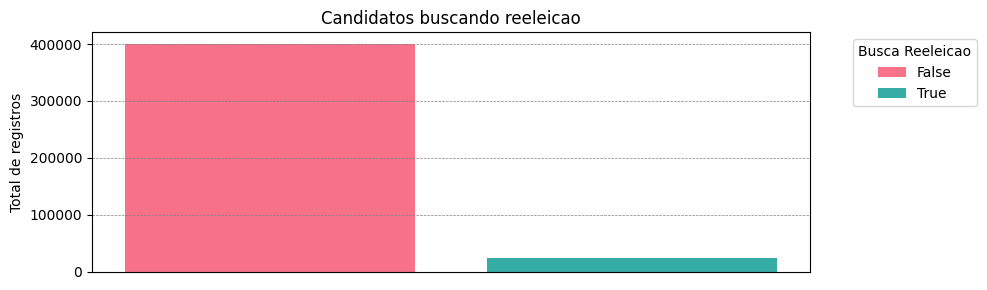

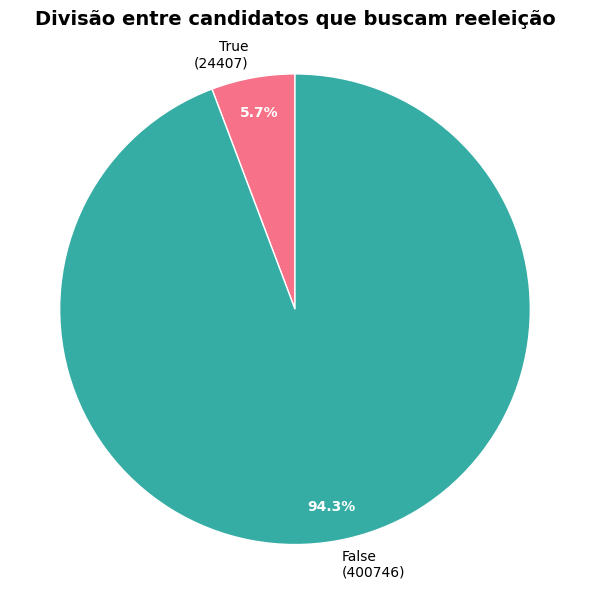

In [26]:
tentativas_reeleicao = count_column_occurencies(dados_de_candidatos, "busca_reeleicao")
tentativas_reeleicao.show(truncate=False)
tentativas_reeleicao_proportions = measure_column_value_proportions(dados_de_candidatos, "busca_reeleicao")
tentativas_reeleicao_proportions.show(truncate=False)

create_bar_chart(
    tentativas_reeleicao,
    category_column_name = "busca_reeleicao",
    count_column_name="count",
    category_label= "Busca Reeleicao",
    count_label = "Total de registros",
    title = "Candidatos buscando reeleicao",
    height = 3, width = 10,
    use_legends=True
).show()

create_pie_chart(
    tentativas_reeleicao,
    category_column_name = "busca_reeleicao",
    count_column_name="count",
    title = "Divisão entre candidatos que buscam reeleição",
    height = 6, width = 6
).show()

Apenas $5,7\%$ dos candidatos buscam a reeleição. Mas ainda assim, por estudos internos, podemos acreditar que este tende a ser um fator de peso, à favor ou contra. E mesmo a proporção sendo tão diferente vamos mantê-los.

### Data de nascimento e Idade

A data de nascimento em si é um campo de menor acoplamento, mas a idade, por ser um número mais fácil de relativizar, é melhor. Para facilitar o cálculo da idade, vou apenas assumir a maior idade possível do candidato no ano da eleição, em 2024, desconsiderando tanto o dia e mês de seu nascimento quanto o dia e mês da eleição. Antes de tudo, sabemos que, pela documentação, pode haver registros com data de nascimento vazia, de antemão, já vamos remover estes registros antes de calcular a data de nascimento.

In [27]:
dados_de_candidatos = dados_de_candidatos\
    .filter(col("data_nascimento") != lit(""))\
    .withColumn("idade", calcula_idade_no_ano_udf(col("data_nascimento"), lit(2024)))\
    .drop("data_nascimento")

dados_de_candidatos.show()

+-----------------+--------------+---+------------------------+-----------------+----------------+---------+--------------------+------------+--------+-----------------+---------------+-----+
|     tipo_eleicao|codigo_eleicao| uf|codigo_unidade_eleitoral|unidade_eleitoral|codigo_candidato|   genero|      grau_instrucao|estado_civil|cor_raca|situacao_no_turno|busca_reeleicao|idade|
+-----------------+--------------+---+------------------------+-----------------+----------------+---------+--------------------+------------+--------+-----------------+---------------+-----+
|ELEIÇÃO ORDINÁRIA|           619| RS|                   85952|            CASCA|    210002366168|MASCULINO|ENSINO FUNDAMENTA...| SOLTEIRO(A)|  BRANCA|    ELEITO POR QP|          false|   52|
|ELEIÇÃO ORDINÁRIA|           619| RS|                   85880|         CASEIROS|    210002245308| FEMININO| SUPERIOR INCOMPLETO| SOLTEIRO(A)|   PARDA|    ELEITO POR QP|          false|   41|
|ELEIÇÃO ORDINÁRIA|           619| RS|  

Idade é um campo numérico, e podemos analisar seus valores de uma forma um pouco mais interessante, medindo também a centralidade e a dispersão.

+-------+------------------+
|summary|             idade|
+-------+------------------+
|  count|            425153|
|   mean| 48.00168174751207|
| stddev|11.797511028133906|
|    min|                18|
|    max|              1050|
+-------+------------------+



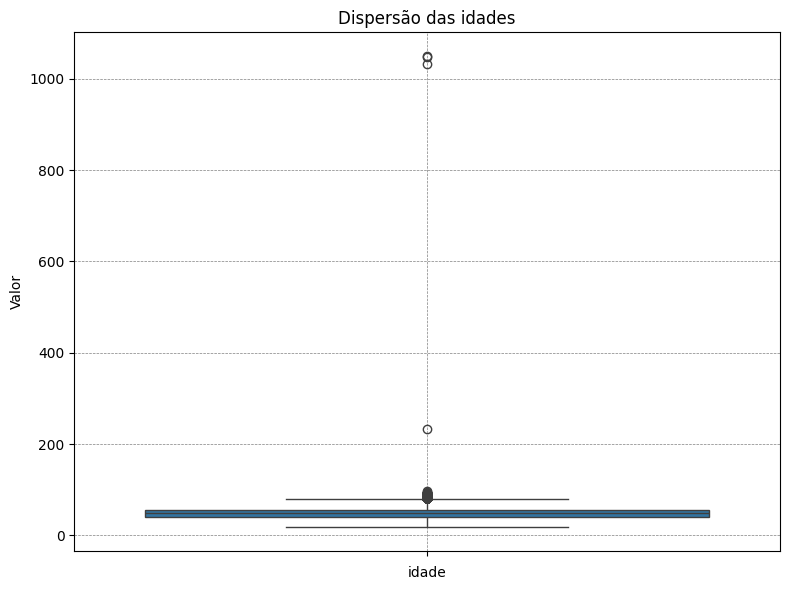

In [28]:
from mvp.visualization import create_box_plot

dados_de_candidatos.select("idade").describe().show()

create_box_plot(
    dados_de_candidatos,
    column_name="idade",
    title = "Dispersão das idades",
    width = 8,
    height = 6
).show()

Fica claro que temos outliers, e que há valores inválidos. A idade mínima legal para candidatura é 18 anos, o que é compatível, mas dificilmente temos um candidato com 1050 anos, então vamos encontrar as maiores idades e remover aquelas que sejam incompatíveis com a realidade.

In [29]:
dados_de_candidatos.select("idade").orderBy(col("idade").desc()).show(5)

+-----+
|idade|
+-----+
| 1050|
| 1047|
| 1032|
|  232|
|   97|
+-----+
only showing top 5 rows



Uma idade de 97 anos é possível para um ser-humano, apesar de raro. Porém, idades de 232 ou superior não. Aqui temos duas opções para definir os valores a serem removidos: podemos remover apenas os valores humanamente impossíveis, como os valores acima de 232 anos, ou tratar os outlier detectados estatísticamente.

Vou assumir uma abordagem híbrida: Vou remover os valores humanamente impossíveis, ou seja, idades acima de 232 anos, e após isso, substituir os outliers pelo valor do limite superior.

In [ ]:
dados_de_candidatos = dados_de_candidatos.filter(col("idade") < lit(232))
dados_de_candidatos = replace_outliers(
    dados_de_candidatos,
    target_column = "idade",
    use_median = False,
    replace_lower = False
)
dados_de_candidatos.select("idade").describe().show()
dados_de_candidatos.orderBy(col("idade").desc()).show(5)
create_box_plot(
    dados_de_candidatos,
    column_name="idade",
    title = "Dispersão das idades",
    width = 8,
    height = 6
).show()

In [ ]:
create_histogram(
    dados_de_candidatos,
    target_column_name= "idade",
    title = "Distribuição da idade dos candidados",
    width=8,
    bin_size=10,
    height=6
).show()

Agora temos uma distribuição mais consistente, mostrando a maioria dos candidatos com idades na faixa de 40 a 50 anos, mas com alta participação também de candidatos entre 50 e 60, o que se parece mais com a realidade da política que conhecemos.

Um próximo passo, para facilitar a integração com o modelo de *machine learning* futuro, é separar a coluna em buckets, vamos assumir 10 anos como um intervalo razoável de segmentação.

In [ ]:
dados_de_candidatos = dados_de_candidatos\
    .withColumn("segmento_idade", segmenta_idade_udf(col("idade")))
dados_de_candidatos.show()

### Situação no turno

A situação no turno é quem define se o candidato foi ou não eleito. Há várias formas de o candidato ser eleito, mas temos interesse apenas em um resultado binário, ou seja, se foi eleito ou não, Vamos estudar estes valores, eliminar os inválidos, e mesclar os grupos entre eleitos e não eleitos.

In [ ]:
count_column_occurencies(
    dados_de_candidatos,
    "situacao_no_turno"
).show()

measure_column_value_proportions(
    dados_de_candidatos,
    "situacao_no_turno"
).show()

Vamos começar eliminando os valores `#NULO`, que pela documentação do dataset, sabemos que são dados inválidos. Então, vamos criar uma nova coluna booleana com o nome `eleito` que condensará como verdadeiro os candidatos na situação `ELEITO POR MÉDIA` e `ELEITO POR QP` e como falso aqueles nas situações `NÃO ELEITO` e `SUPLENTE`.

In [ ]:
dados_de_candidatos = dados_de_candidatos\
    .filter(col("situacao_no_turno") != lit("#NULO"))\
    .withColumn("eleito", mescla_situacao_no_turno_udf(col("situacao_no_turno")))\
    .drop("situacao_no_turno")

In [ ]:
resultado_candidato = count_column_occurencies(dados_de_candidatos, "eleito")
resultado_candidato.show(truncate=False)

resultado_candidato_proportions = measure_column_value_proportions(dados_de_candidatos, "eleito")
resultado_candidato_proportions.show(truncate=False)

create_bar_chart(
    resultado_candidato,
    category_column_name = "eleito",
    count_column_name="count",
    category_label= "Eleito",
    count_label = "Total de registros",
    title = "Resultado do Candidato",
    height = 3, width = 10,
    use_legends=True
).show()

create_pie_chart(
    resultado_candidato,
    category_column_name = "eleito",
    count_column_name="count",
    title = "Divisão entre candidatos eleitos ou não",
    height = 6, width = 6
).show()

A análise geral mostra que em torno de $14\%$ dos candidatos foi eleita. Isso da fim a etapa de pre-processamento do dataset de candidados separado dos demais. Agora, vamos seguir para o dataset de bens de candidatos e de vagas, para posteriormente fazer um pré-processamento e uma análise do dataset conjunto resultante.

## Bens de candidatos

Agora vamos trabalhar com o dataset de bens de candidatos. Vamos considerar apenas o valor dos bens, então, podemos nos limitar a excluir dados inválidos e somar os bens totais de cada candidato.

In [ ]:
bens_de_candidatos = load_data_source(spark, bens_de_candidados_source_path)
bens_de_candidatos.show(10, truncate=False)

Há diversas colunas que não são relevantes, mas podemos concentrar apenas nas relevantes.

* Para mesclar com o dataset de candidatos, precisamos apenas do código da eleição (`CD_ELEICAO`), código da uniade eleitoral (`SG_UE`) e o id do candidato (`SQ_CANDIDATO`)
* Para calcular o patrimônio dos candidatos, precisamos apenas da coluna correspondente ao valor do bem (`VR_BEM_CANDIDATO`).
* Vamos filtrar apenas por eleições ordinárias (`CD_TIPO_ELEICAO = 2`), embora, isso não seja uma preocupação, já que o código da eleição também é um critério
* Vamos remover bens de valor nulo ou vazio

In [ ]:
bens_de_candidatos = bens_de_candidatos\
    .filter((col("CD_TIPO_ELEICAO") == lit(2)) & (col("VR_BEM_CANDIDATO") != lit("")) & (col("VR_BEM_CANDIDATO").isNotNull()))\
    .select("CD_ELEICAO", "SG_UE", "SQ_CANDIDATO", "DS_TIPO_BEM_CANDIDATO", "VR_BEM_CANDIDATO")\
    .withColumnRenamed("CD_ELEICAO", "codigo_eleicao")\
    .withColumnRenamed("SG_UE", "codigo_unidade_eleitoral")\
    .withColumnRenamed("SQ_CANDIDATO", "codigo_candidato")\
    .withColumnRenamed("DS_TIPO_BEM_CANDIDATO", "tipo_do_bem")\
    .withColumnRenamed("VR_BEM_CANDIDATO", "valor_do_bem")

bens_de_candidatos.printSchema()

bens_de_candidatos.show(5, truncate=False)

Um ponto de atenção é que o valor do bem está sendo carregado como texto, e precisamos que seja numérico. Vamos convertê-lo.

In [ ]:
bens_de_candidatos = bens_de_candidatos\
    .withColumn("valor_do_bem", parse_text_to_float_udf(col("valor_do_bem")))

bens_de_candidatos.printSchema()

In [ ]:
bens_de_candidatos.select("valor_do_bem").describe().show()

Pelo valor máxmo, fica claro que há ao menos um valor errado no dataset, pois o valor máximo corresponde a *dez bilhões, seiscentos milhões, duzentos e cinquenta mil*. Há também bens com valor 0, o que é contraditório. Vamos garantir bens apenas com valores maiores que zero e começar analisando os bens mais caros e mais baratos, mesmo sabendo que se tratam de tipos de bens diferentes, e observar outros outliers:

In [ ]:
bens_de_candidatos = bens_de_candidatos.filter(col("valor_do_bem") > 0)

bens_de_candidatos.select("tipo_do_bem", "valor_do_bem")\
    .orderBy(col("valor_do_bem").desc())\
    .show(10, truncate=False)

bens_de_candidatos.select("tipo_do_bem", "valor_do_bem")\
    .orderBy(col("valor_do_bem").asc())\
    .show(10, truncate=False)

Vemos que ainda existem valores da ordem de um dois mais *bilhões* de reais, o que é demais para um único ítem do patrimônio, sugerindo um erro de digitação ou algo do tipo. Há também valores de $R\$0,01$, sugerindo que foi preenchido um valor mínimo apenas para declarar. Vamos eliminar estes outliers de forma estatística.

Será necessário analisar os outliers de cada tipo de bem, já que não é possível comparar bens de tipos diferentes. Temos certeza que há problemas, uma vez que existem valores incompatíveis, pois temos, por exemplo, um veículo automotor terrestre de $R\$65$ milhões, e uma casa de $R\$400$ milhões.

In [ ]:
dispersao_dos_bens = \
    calculate_group_dispersion(
        bens_de_candidatos,
        categories_column="tipo_do_bem",
        target_column="valor_do_bem",
        include_target_column_on_column_names = True,
        count_outliers = True,
    )

In [ ]:
dispersao_dos_bens\
    .orderBy(col("tipo_do_bem").desc())\
    .show(dispersao_dos_bens.count(), truncate=False)

Na tabela anterior, vemos um número considerável de outliers superiores, não há outliers inferiores por que o valor de corte para o IQN será negativo. Em alguns casos, chegamos a ter alguns milhares de ítens acima do limite superior. O Gráfico de dispersão confirma o temor de grande subdeclaração, onde muitos bens são declarados com valores baixos, de forma que valores de bens próximos à zero não são considerados outliers.

In [ ]:
create_box_plot(
    bens_de_candidatos.orderBy(col("tipo_do_bem").desc()),
    column_name="valor_do_bem",
    categories_column_name="tipo_do_bem",
    title = "Valores de bens por tipo",
    width = 50,
    height = 15,
    x_label = "Tipos de bens",
    y_label = "Valor do bem",
    log_scale = True,
).show()

Agora, uma versão do dataframe com os outliers de cada tipo de bens removidos:

In [ ]:
bens_de_candidatos = \
    remove_group_outliers(
        bens_de_candidatos,
        categories_column="tipo_do_bem",
        target_column="valor_do_bem"
    )

Vamos visualizar a dispersão do novo data frame

In [ ]:
create_box_plot(
    bens_de_candidatos.orderBy(col("tipo_do_bem").desc()),
    column_name="valor_do_bem",
    categories_column_name="tipo_do_bem",
    title = "Valores de bens por tipo (outliers removidos)",
    width = 50,
    height = 15,
    x_label = "Tipos de bens",
    y_label = "Valor do bem",
    log_scale = True,
).show()

Após a remoção dos outrliers, ainda vemos que existe um prolema de subdeclaração que não pode ser resolvido, pois mostra registros inconsistentes de valores dos dados, como vimos em etapas anteriores, os registros de valor de $R\$0,01$ por exemplo.

In [ ]:
dispersao_dos_bens = \
    calculate_group_dispersion(
        bens_de_candidatos,
        categories_column="tipo_do_bem",
        target_column="valor_do_bem",
        include_target_column_on_column_names = True,
        count_outliers = True,
    )

dispersao_dos_bens = dispersao_dos_bens\
    .orderBy(col("tipo_do_bem").desc())\

dispersao_dos_bens\
    .show(dispersao_dos_bens.count(), truncate=False)

Agora, vamos combinar os valores de bens, criando um dataset com o patrimômio de cada candidato.

In [ ]:
patrimonio_dos_candidatos = calcula_patrimonio(
    bens_de_candidatos,
    codigo_candidato_column = "codigo_candidato",
    codigo_eleicao_column = "codigo_unidade_eleitoral",
    valor_do_bem_column = "valor_do_bem"
)

patrimonio_dos_candidatos\
    .orderBy(col("patrimonio").desc())\
    .show()

Para analisar a dispersão do patrimômio, precisamos comparar candidatos que competem entre sí, ou seja, que estão competindo na mesma unidade eleitoral. Com isso, podemos ter uma visão do dado neste cenário. Como há muitas unidades eleitorais a visualização de todas é complexa. Vamos fazer a seguinte escolha a para análise:

* Vamos selecionar algumas unidades eleitorais que contém os candidatos com maior patrimõmio
* Vamos selecionar algumas unidades eleitorais que contém os candidatos com menor patrimõmio
* Para cada grupo (maiores e menores), vamos plotar o gráfico das suas unidades eleitorais.

In [ ]:
import pyspark.sql.functions as F

unidades_eleitorais_com_maior_patrimonio = patrimonio_dos_candidatos.select("codigo_unidade_eleitoral", "patrimonio")\
    .groupBy("codigo_unidade_eleitoral")\
    .agg(F.max(col("patrimonio")).alias("patrimonio"))\
    .orderBy(col("patrimonio").desc())\
    .select("codigo_unidade_eleitoral")
unidades_eleitorais_com_maior_patrimonio.show()

unidades_eleitorais_com_menor_patrimonio = patrimonio_dos_candidatos.select("codigo_unidade_eleitoral", "patrimonio")\
    .groupBy("codigo_unidade_eleitoral")\
    .agg(F.min(col("patrimonio")).alias("patrimonio"))\
    .orderBy(col("patrimonio").asc())\
    .select("codigo_unidade_eleitoral")
unidades_eleitorais_com_menor_patrimonio.show()

In [ ]:
entrada_para_box_plot =\
    unidades_eleitorais_com_maior_patrimonio.limit(10)\
        .join(patrimonio_dos_candidatos, on = ["codigo_unidade_eleitoral"], how = "inner")

create_box_plot(
    entrada_para_box_plot,
    column_name="patrimonio",
    categories_column_name="codigo_unidade_eleitoral",
    title = "Unidades com candidatos de maior patrimônio",
    width = 30,
    height = 10,
    y_label = "Patrimônio",
    x_label = "Unidade eleitoral",
).show()


entrada_para_box_plot =\
    unidades_eleitorais_com_menor_patrimonio.limit(10)\
        .join(patrimonio_dos_candidatos, on = ["codigo_unidade_eleitoral"], how = "inner")

create_box_plot(
    entrada_para_box_plot,
    column_name="patrimonio",
    categories_column_name="codigo_unidade_eleitoral",
    title = "Unidades com candidatos de menor patrimônio",
    width = 30,
    height = 10,
    y_label = "Patrimônio",
    x_label = "Unidade eleitoral",
).show()


Comprando a distribuição de patrimônio nas unidades eleitorais, entendemos uma situação interessante: De um modo geral, os valores parecem bem comportados dentro das unidades eleitorais, claro, há outliers. Uma dúvida é se estes outliers devem ser considerados erros. Considerando os valores observados (da ordem de até um milhão de reais nas unidades com maior patrimômio) e de até R$700k nas uniades de menor patrimônio, vemos que são valores compatíveis com a realidade brasileira, sobretudo na política, e faz sentido considerar estes outliers como fruto de desigualdade social e não removê-los.

## Vagas

Agora vamos carregar e preparar os dados de vagas. Estes dados são mais simples, tudo que precisamos é associar as vagas ás unidades eleitorais. AS vagão serão usadas apenas como uma feature de entrada do nosso dataset de treino, afinal, as chances de eleição devem crescer se houver mais vagas disponíveis para uma dada unidade.

In [ ]:
vagas_por_eleicao = load_data_source(spark, vagas_por_eleicao_source_path)
vagas_por_eleicao.printSchema()
vagas_por_eleicao.show(truncate=False)

Precisamos de poucas colunas, apenas a descrição do cargo para filtragem (`DS_CARGO`), a quantidade de vagas (`QT_VAGA`), o código da unidade eleitoral (`SG_UE`), e o código da eleição (`CD_ELEICAO`).

In [ ]:
vagas_por_eleicao = \
    vagas_por_eleicao\
        .select(
            "DS_CARGO",
            "QT_VAGA",
            "SG_UE",
            "CD_ELEICAO"
        )\
        .withColumnRenamed("DS_CARGO", "cargo")\
        .withColumnRenamed("SG_UE", "codigo_unidade_eleitoral")\
        .withColumnRenamed("CD_ELEICAO", "codigo_eleicao")\
        .withColumn("QT_VAGA", col("QT_VAGA").cast("int"))\
        .withColumnRenamed("QT_VAGA", "vagas")\
        .filter(col("cargo") == lit("Vereador"))\
        .drop("cargo")

vagas_por_eleicao.printSchema()
vagas_por_eleicao.show(truncate=False)

Vamos montar agora o dataset completo, com toda a informação que precisamos para o modelo. Primeiro, juntando informações de candidatos com as informaçẽos de vagas disponíveis nas unidades eleitorais nas quais competem:

In [ ]:
candidaturas_com_vagas = \
    dados_de_candidatos.\
        join(vagas_por_eleicao, on = ["codigo_unidade_eleitoral", "codigo_eleicao"])

candidaturas_com_vagas.printSchema()
candidaturas_com_vagas.show(truncate=False)

Agora, juntando a informação de patrimônio dos candidados à este resultado.

In [ ]:
candidaturas_com_vagas_e_patrimonio = \
    candidaturas_com_vagas\
        .join(patrimonio_dos_candidatos, on = ["codigo_unidade_eleitoral", "codigo_candidato"], how = "inner")\
        .orderBy(
            col("codigo_unidade_eleitoral").asc(),
            col("codigo_candidato").asc()
        )\
        .select(
            "codigo_unidade_eleitoral",
            "codigo_candidato",
            "genero",
            "grau_instrucao",
            "estado_civil",
            "cor_raca",
            "idade",
            "segmento_idade",
            "patrimonio",
            "busca_reeleicao",
            "vagas",
            "eleito",
        )

In [ ]:
candidaturas_com_vagas_e_patrimonio.printSchema()
candidaturas_com_vagas_e_patrimonio.show(truncate=False)

Vamos fazer algumas análises que nos permitam responder perguntas, ou levantar novas dúvidas, sobre a relação entre as colunas e os dados. Com um dado tão complexo, dificilmente uma única coluna teria relação forte direta com a variável alvo `eleito`, mas podemos fazer alguns estudos iniciais. Vamos começar separando os datasets em dois grupos, os eleitos e não eleitos:

In [ ]:
candidatos_eleitos = candidaturas_com_vagas_e_patrimonio.filter(col("eleito") == lit(True))
candidatos_nao_eleitos = candidaturas_com_vagas_e_patrimonio.filter(col("eleito") == lit(False))

In [ ]:
candidatos_eleitos.select("idade", "patrimonio", "vagas").describe().show(truncate=False)

In [ ]:
candidatos_nao_eleitos.select("idade", "patrimonio", "vagas").describe().show(truncate=False)

Já vimos que entre as classes eleito/não eleito há um grande desbalanceamento, então conclusões feitas à partir deste dados seriam muito prejudiciais para a relação com o resultado. Além disso, a análide da relação entre colunas é prejudicada pelo tamanho do dataset (maior do que o colab suporta).

En lugar de tratar este problema, como um problema de classificação, podemos trata-lo como um problema de regressão com algumas transformações.

## Análise e Preparação dos dados de treino

Agora podemos construir os data frames de treinamento e teste. Considerar a variávei `eleito` como variável alvo pode tornar o aprendizado muito complicado, uma forma mais interessante pode usar como variável alvo a taxa de sucesso daquele grupo. Uma forma de resolver isso, é agrupar o dataframe pelas diferentes features gerando uma nova feature para cada eleição.

A probabilidade de um candidato qualquer ser eleito é o número de vagas ($v$$) multiplicado por $\dfrac{1}{c}$, onde $c$ é o número de candidatos concorrendo à mesma vaga, ou seja $\dfrac{v}{c}$, a hipótese é que esta probabilidade seja alterada de acordo com certas características dos candidatos.

Em lugar de avaliar os candidatos individualmente para o problema de classificação, vamos preparar os dados para um modelo que avalia as probabilidades de eleição dentro de um grupo condicionadas às suas features.

In [ ]:
import pyspark.sql.functions as F

taxas_eleicoes = \
    candidaturas_com_vagas_e_patrimonio\
        .groupBy(
            "codigo_unidade_eleitoral",
            "genero",
            "grau_instrucao",
            "estado_civil",
            "cor_raca",
            "segmento_idade",
            "busca_reeleicao",
            "vagas"
        )\
        .agg(
            F.median(col("patrimonio")).alias("patrimonio"),

            F.count(col("codigo_candidato")).alias("total_candidatos"),

            F.sum(F.when(col("eleito"), lit(1)).otherwise(0)).alias("total_eleitos"),
        )\
        .withColumn("taxa_eleitos", col("total_eleitos")/col("vagas"))

Como esses dados foram gerados à partir dos datasets que viemos analisando e trabalhando, já conhecemos os tipos de dados, mas vale revisitar esse ponto por mais clareza:

In [ ]:
taxas_eleicoes.printSchema()

Vamos começar observando as primeiras linhas do dataset final:

In [ ]:
taxas_eleicoes.show(truncate=False)

Parece haver muitos valores zero para a taxa de eleitos, vamos fazer um histograma para a taxa de eleitos e confirmar.

In [ ]:
create_histogram(
    taxas_eleicoes,
    target_column_name="taxa_eleitos",
    bins=10,
    title = "Distribuição da taxa de eleitos condicionada",
).show()

Como esperado, a maioria dos grupos está próximo a zero, mas surpreendentemente, há grupos com taxas mais altas, que podem estar ligados a municípios com poucas vagas o que levam a taxas altas.

Vamos analisar um histograma com o patrimônio dos grupos

In [ ]:
create_histogram(
    taxas_eleicoes,
    target_column_name="patrimonio",
    bins=50,
    title = "Distribuição dos patrimônios condicionados",
).show()

Ao analisar os candidatos individualmente nós vimos uma alta concentração do patrimônio em valores mais baixos, porém com alguns valores da ordem de milhões. O mesmo se reflete aqui ao analisarmos os grupos. Mostrando que a distribuição de patrimônio ao longo das eleções tem uma característica consistente com os fatores demográficos e/ou com a geografia.

Vamos analisar a distribuição dos atributos demográficos. Vou apresentar todos e trazer algumas conclusões ao final.

In [ ]:
distribuicao_de_genero = count_column_occurencies(taxas_eleicoes, "genero")
create_pie_chart(
    distribuicao_de_genero,
    category_column_name="genero",
    title = "Distribuição dos gêneros",
    width = 6,
).show()

In [ ]:
distribuicao_de_grau_de_instrucao = count_column_occurencies(taxas_eleicoes, "grau_instrucao")
distribuicao_de_grau_de_instrucao = sort_by_categorical_field(
    spark, distribuicao_de_grau_de_instrucao, GRAUS_DE_INSTRUCAO_SORT_ORDER, "grau_instrucao")
create_bar_chart(
    distribuicao_de_grau_de_instrucao,
    category_column_name="grau_instrucao",
    title = "Distribuição dos Graus de instrução",
    category_label = "Grau de instrução",
    width = 25
).show()

In [ ]:
distribuicao_de_estado_civil = count_column_occurencies(taxas_eleicoes, "estado_civil")
create_bar_chart(
    distribuicao_de_estado_civil,
    category_column_name="estado_civil",
    title = "Distribuição dos Estados civis",
    width = 10,
    category_label = "Estado civil"
).show()

In [ ]:
distribuicao_de_cor_raca = count_column_occurencies(taxas_eleicoes, "cor_raca")
create_bar_chart(
    distribuicao_de_cor_raca,
    category_column_name="cor_raca",
    title = "Distribuição de Cor/Raça",
    width = 10,
    category_label = "Cor/Raça"
).show()

In [ ]:
distribuicao_de_segmento_idade = count_column_occurencies(taxas_eleicoes, "segmento_idade")
create_bar_chart(
    distribuicao_de_segmento_idade,
    category_column_name="segmento_idade",
    title = "Distribuição das Faixas Etárias",
    width = 10,
    category_label = "Faixa Etária"
).show()

In [ ]:
distribuicao_de_recandidatura = count_column_occurencies(taxas_eleicoes, "busca_reeleicao")
create_bar_chart(
    distribuicao_de_recandidatura,
    category_column_name="busca_reeleicao",
    title = "Distribuição dos grupos segundo busca por Reeleição",
    width = 5,
    category_label = "Busca Reeleição"
).show()

De todas as observações, a mais clara, que se repete em todos os casos, é que o tamaho dos grupos é consideravelmente diferente, o que, dependendo da abordagem utilizada, pode prejudicar muito o aprendizado. Outra observação é que alguns grupos se destacam: O gênero `MASCULINO` e o grau de instrução `ENSINO MÉDIO COMPLETO` (`SUPERIOR COMPLETO` também tem uma participação próxima, juntos dominam o grau de instrução), então é de se esperar que haja maior incidência de eleições com estas features. Essa discrepância das features categoricas, potencialmente prejudica a análise.

Outro ponto curioso é a districuição de faixas etárias, que é simétrica, lembrando muito uma distribuição normal.

Sobre cor, brancos e pardos tem ocorrência maior. Como última análise, vamos tentar uma combinação de dados sociodemográficos e validar se há diferença clara esperada na distribuição de patrimônio as raças.

In [ ]:
create_histogram(
    taxas_eleicoes.filter(col("cor_raca") == lit("BRANCA")),
    target_column_name="patrimonio",
    bins=50,
    title = "Distribuição dos patrimônios Para cor = BRANCA",
    y_label = "Grupos",
    height = 4, width = 8,
    stat = 'probability'
).show()

create_histogram(
    taxas_eleicoes.filter(col("cor_raca") == lit("PRETA")),
    target_column_name="patrimonio",
    bins=50,
    title = "Distribuição dos patrimônios Para cor = PRETA",
    y_label = "Grupos",
    height = 4, width = 8,
    stat = 'probability'
).show()

create_histogram(
    taxas_eleicoes.filter(col("cor_raca") == lit("PARDA")),
    target_column_name="patrimonio",
    bins=50,
    title = "Distribuição dos patrimônios Para cor = PARDA",
    y_label = "Grupos",
    height = 4, width = 8,
    stat = 'probability'
).show()

Vemos que para os declarados pretos, há uma frequẽncia maior de grupos com menor patrimônio.

In [ ]:
create_histogram(
    taxas_eleicoes.filter(col("cor_raca") == lit("BRANCA")),
    target_column_name="taxa_eleitos",
    bins=100,
    title = "Distribuição das taxas de eleitos Para cor = BRANCA",
    y_label = "Grupos",
    height = 4, width = 8,
    stat = 'probability'
).show()

create_histogram(
    taxas_eleicoes.filter(col("cor_raca") == lit("PRETA")),
    target_column_name="taxa_eleitos",
    bins=100,
    title = "Distribuição das taxas de eleitos Para cor = PRETA",
    y_label = "Grupos",
    height = 4, width = 8,
    stat = 'probability'
).show()

create_histogram(
    taxas_eleicoes.filter(col("cor_raca") == lit("PARDA")),
    target_column_name="taxa_eleitos",
    bins=100,
    title = "Distribuição das taxas de eleitos Para cor = PARDA",
    y_label = "Grupos",
    height = 4, width = 8,
    stat = 'probability'
).show()

Analisando o gráfico, não parece haver diferença considerável entre as taxas de eleição para as diferentes raças. As demais features categóricas oferecem muita discrepância entre as categorias, dificultando uma análise geral.

Com isso, temos a resposta para nossas hipóteses sobre raça: Não parece haver uma relação clara entre a raça do candidato e suas chances de sucesso, porém, parece sim haver uma relação, ainda que baixa, entre a raça do candidato e seu patrimônio, sobretudo para candidatos declarados PRETOS.

O número de candidatos que busca reeleição, comparado ao de candidatos não-vereadores, é muito baixo, mas vamos fazer um histograma e comparar a taxa de eleitos nestes grupos.

In [ ]:
create_histogram(
    taxas_eleicoes.filter(col("busca_reeleicao") == lit(True)),
    target_column_name="taxa_eleitos",
    bins=100,
    title = "Distribuição da taxa de sucesso para candidatos que buscam reeleição",
    y_label = "Grupos",
    height = 4, width = 8,
    stat = 'probability'
).show()

create_histogram(
    taxas_eleicoes.filter(col("busca_reeleicao") == lit(False)),
    target_column_name="taxa_eleitos",
    bins=100,
    title = "Distribuição da taxa de sucesso para candidatos que não são vereadores",
    y_label = "Grupos",
    height = 4, width = 8,
    stat = 'probability'
).show()

Fica claro que o número de grupos, com taxa de reeleição em torno de 0.1 ou 0.2 é proporcionalmente maior para candidatos que tentam reeleição, ou seja, o fato de já ser um vereador influencia fortemente nas chances de reeleição, o que responde mais uma das nossas hipóteses.

Para avaliar a relação do patrimômio com a taxa de sucesso.

In [ ]:
from mvp.visualization import create_line_chart


create_line_chart(
    taxas_eleicoes,
    x_column_name="patrimonio",
    y_column_name="taxa_eleitos",
    title = "Relação entre Patimônio e taxa de eleição",
    height = 6, width = 6,
    x_label = "Patrimônio do grupo",
    y_label = "Taxa de eleitos",
    linewidth = 0
).show()

Neste gráfico não parece haver nenhuma relação clara entre o patrimônio e a taxa de sucesso. Mas como já sabemos que existe uma relação forte entre a reeleição e a taxa de sucesso, vamos separar estes grupos.

In [ ]:
create_line_chart(
    taxas_eleicoes.filter(col("busca_reeleicao") == lit(False)),
    x_column_name="patrimonio",
    y_column_name="taxa_eleitos",
    title = "Relação entre Patimônio e taxa de eleição (não são vereadores)",
    height = 6, width = 6,
    x_label = "Patrimônio do grupo",
    y_label = "Taxa de eleitos",
    linewidth = 0
).show()


In [ ]:

create_line_chart(
    taxas_eleicoes.filter(col("busca_reeleicao") == lit(True)),
    x_column_name="patrimonio",
    y_column_name="taxa_eleitos",
    title = "Relação entre Patimônio e taxa de eleição (buscam reeleição)",
    height = 6, width = 6,
    x_label = "Patrimônio do grupo",
    y_label = "Taxa de eleitos",
    linewidth = 0
).show()

Vamos calcular as correlações e verificar se há diferença significativa.

In [ ]:
correcao_patrimonio_reeleicao = taxas_eleicoes.filter(col("busca_reeleicao") == lit(True)).stat.corr("taxa_eleitos", "patrimonio")
correcao_patrimonio_sem_reeleicao = taxas_eleicoes.filter(col("busca_reeleicao") == lit(False)).stat.corr("taxa_eleitos", "patrimonio")

print(f"A correção para os que buscam reeleição é {correcao_patrimonio_reeleicao} e para os que não são vereadores é {correcao_patrimonio_sem_reeleicao}")

Pelo gráfico qualquer observação é inconclusiva. Porém, pela correlação calculada, vemos uma tendência de crescimento muito fraca nos candidatos que não são vereadores e uma correlação negativa, ou seja, uma tendência de crescimento contrátio (e também muito fraca) para os que já são vereadores, sugerindo que estamos num cenário onde candidatos que que tentam reeleição são menos dependêntes do patrimônio para se reeleger.

## Preparação dos dados para treinamento

Após a análise do dado final, vamos preparar o dado para treinamento. Utilizarei um pipeline do Spark ML para a preparação. As etapas serão:

* Executar o split do dado em treino e validação (demais etapas serão seguidas para o split de treinamento)
* Indexar as colunas categóricas (pois os modelos tratam valores numéricos, e precisarei de one-hot)
* Criar one-hot para as colunas categóricas indexadas
* Combinar os vetores one-hot gerados e as features numéricas num vetor só (o spark precisa de um único vetor para seus modelos de, incluindo as transformações de escala)
* Escalar o vetor final (resultando na transformação de escala das features numéricas)

As features utilizadas no treinamento serão:

* genero
* grau_instrucao
* estado_civil
* cor_raca
* segmento_idade
* busca_reeleicao
* vagas
* patrimonio

E a feature alvo da regressão será `taxa_eleitos`

Primeiro passo, é converter a coluna `busca_reeleicao` para inteiro, pois não podemos indexa-la sendo do tipo booleano. Assim, usamos a função `separa_treino_e_teste`, para separar uma amostra de teste do dataset, assim, o pipeline de feature engineering pode ser feito apenas na de treino.

In [ ]:
taxas_eleicoes = taxas_eleicoes.withColumn("busca_reeleicao", col("busca_reeleicao").cast("int"))
taxas_eleicoes_treino, taxas_eleicoes_teste = separa_treino_e_teste(taxas_eleicoes, 0.2, seed=12438978543)

Com o pipeline montado, o próximo passo é "treiná-lo", no spark, um pipeline de feature engineering é como um modelo, e os indexers e one-hot encoders são aprendidos como modelos.

In [ ]:
pipeline_de_feature_engineering = preapre_feature_engineering_pipeline(taxas_eleicoes)

dados_para_treino = pipeline_de_feature_engineering.transform(taxas_eleicoes_treino)
dados_para_teste = pipeline_de_feature_engineering.transform(taxas_eleicoes_teste)

Uma vez que o treinamento foi concluído e dado transfomado, temos os dados de treino e teste disponíveis. Podemos salvar para uso futuro ou prosseguir com o treinamento de um modelo.

In [ ]:
dados_para_treino = dados_para_treino\
    .select("codigo_unidade_eleitoral", "features_scaled", "taxa_eleitos")
dados_para_treino.show()

dados_para_teste = dados_para_teste\
    .select("codigo_unidade_eleitoral", "features_scaled", "taxa_eleitos")
dados_para_teste.show()

Ao final de tudo, vou salvar os dados.

In [ ]:
taxas_eleicoes_output_path = os.path.join(output_path, "completo")
taxas_eleicoes.write.parquet(taxas_eleicoes_output_path)

dados_para_treino_output_path = os.path.join(output_path, "treino")
dados_para_treino.write.parquet(dados_para_treino_output_path)

dados_para_teste_output_path = os.path.join(output_path, "teste")
dados_para_teste.write.parquet(dados_para_treino_output_path)

pipeline_de_feature_engineering_output_path = os.path.join(output_path, "feature_engineering_pipeline")
pipeline_de_feature_engineering.save(pipeline_de_feature_engineering_output_path)